In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModel,
    Trainer,
    TrainingArguments,
    EvalPrediction,
)

In [ ]:
#mDeBERTa model
model_name = "microsoft/mdeberta-v3-base"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

df_path = r"C:\Users\Utente1\Desktop\Finetuning-HFT\Final_Augmented_Labeled_Data.csv"  
df = pd.read_csv(df_path)
df["label"] = df["label"].astype(int)

print("Sample from dataset:")
print(df.head())
print("Class distribution:")
print(df["label"].value_counts())

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    stratify=df["label"],
    random_state=42,
)


In [3]:
# Define a tokenization function for our texts.
def tokenize_texts(texts, tokenizer):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt",
    )

# Create a custom Dataset class.
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenize_texts(texts, tokenizer)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Each item includes input_ids, attention_mask, etc., plus a label.
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Instantiate the training and validation datasets.
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)


In [18]:
# Custom model that uses the 7th intermediate layer's CLS embedding for classification.
class DebertaV3IntermediateForSequenceClassification(nn.Module):
    def __init__(self, model_name: str, num_labels: int, intermediate_layer: int = 7, dropout_prob: float = 0.1):
        """
        model_name: Pretrained Italian mDeBERTa model name.
        num_labels: Number of classes.
        intermediate_layer: Which transformer layer's output to use (e.g., 7).
        dropout_prob: Dropout probability.
        """
        super(DebertaV3IntermediateForSequenceClassification, self).__init__()
        # Load configuration with output_hidden_states enabled.
        config = AutoConfig.from_pretrained(model_name, output_hidden_states=True)
        self.deberta = AutoModel.from_pretrained(model_name, config=config)
        hidden_size = config.hidden_size

        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Linear(hidden_size, num_labels)
        self.intermediate_layer = intermediate_layer

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        # Forward pass through the mDeBERTa model.
        outputs = self.deberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        # outputs.hidden_states is a tuple: (embeddings, layer1, layer2, ..., layerN)
        hidden_states = outputs.hidden_states
        if self.intermediate_layer >= len(hidden_states):
            raise ValueError(
                f"Requested intermediate layer {self.intermediate_layer} but model only has {len(hidden_states)-1} layers."
            )
        # Extract the 7th layer (or your chosen intermediate layer)
        layer_hidden_state = hidden_states[self.intermediate_layer]  # Shape: (batch_size, seq_length, hidden_size)
        # Use the CLS token embedding (first token) for classification.
        cls_embedding = layer_hidden_state[:, 0, :]  # Shape: (batch_size, hidden_size)
        cls_embedding = self.dropout(cls_embedding)
        logits = self.classifier(cls_embedding)

        output = {"logits": logits}
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            output["loss"] = loss
        return output

# Instantiate the model.
num_labels = len(set(df["label"].tolist()))
model = DebertaV3IntermediateForSequenceClassification(model_name, num_labels=num_labels, intermediate_layer=7)
model = model.to("cuda")


AttributeError: 'DebertaV3IntermediateForSequenceClassification' object has no attribute 'summary'

In [5]:
# Compute metrics function for evaluation during training.
def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = (predictions == labels).mean()
    return {"accuracy": accuracy}

# Collate function to combine batches.
def collate_fn(batch):
    return {
        "input_ids": torch.stack([item["input_ids"] for item in batch]),
        "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
        "labels": torch.tensor([item["labels"] for item in batch]),
    }



In [ ]:
# Define training arguments.
training_args = TrainingArguments(
    output_dir="./mdeberta_intermediate_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,  # Adjust as needed.
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Create the Trainer instance.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)



In [ ]:
trainer.summary()
# Fine-tune the model.
trainer.train()

# Evaluate on the validation set.
trainer.evaluate()

# Save the fine-tuned model.
trainer.save_model("./mdeberta_intermediate_finetuned")

AttributeError: 'Trainer' object has no attribute 'summary'

Softmax Scores: [[0.28221998 0.51085293 0.20692705]]
Max Confidence: 0.5108529329299927
Energy Score: -1.1248486042022705
Predicted Class: Unknown
Energy Score: -1.1248486042022705
Softmax Scores: [[0.9033068  0.05574089 0.04095231]]
Max Confidence: 0.903306782245636
Energy Score: -1.9866366386413574
Softmax Scores: [[0.12873302 0.71836853 0.15289845]]
Max Confidence: 0.7183685302734375
Energy Score: -1.4094927310943604
Softmax Scores: [[0.93272513 0.03995006 0.02732478]]
Max Confidence: 0.9327251315116882
Energy Score: -2.2054505348205566
Softmax Scores: [[0.9317703  0.04093316 0.02729652]]
Max Confidence: 0.9317703247070312
Energy Score: -2.215067148208618
Softmax Scores: [[0.1660751  0.28091    0.55301493]]
Max Confidence: 0.5530149340629578
Energy Score: -1.190051555633545
Softmax Scores: [[0.1671445  0.71020156 0.12265397]]
Max Confidence: 0.7102015614509583
Energy Score: -1.3731844425201416
Softmax Scores: [[0.9424678  0.03561871 0.02191352]]
Max Confidence: 0.9424678087234497
En

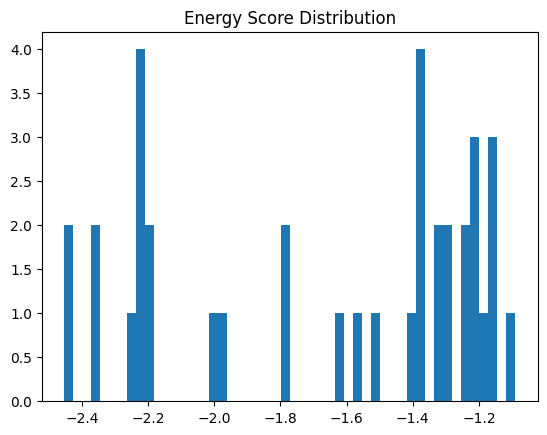

In [16]:
import pandas as pd
def predict_with_intermediate_layer(text, energy_threshold=-5.0, confidence_threshold=0.6):
    # Tokenize the input text.
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=256)
    inputs = {key: value.to("cuda") for key, value in inputs.items()}
    
    # Get model outputs.
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs["logits"]
    softmax_scores = torch.softmax(logits, dim=1)
    max_confidence = torch.max(softmax_scores, dim=1)[0].item()
    predicted_class = torch.argmax(logits, dim=1).item()
    
    # Compute an energy score as -logsumexp over logits.
    energy = -torch.logsumexp(logits, dim=1).item()
    
    print("Softmax Scores:", softmax_scores.cpu().numpy())
    print("Max Confidence:", max_confidence)
    print("Energy Score:", energy)
    
    if max_confidence < confidence_threshold or energy > energy_threshold:
        return "Unknown", energy
    return predicted_class, energy

# # Load the cleaned inference CSV
# df_clean = pd.read_csv(r"C:\Users\Utente1\Desktop\Finetuning-HFT\output.csv")

# # Run predictions on the cleaned text and print the results
# for text in df_clean["text"].tolist():
#     pred_class, score = predict_with_intermediate_layer(text)  # Use your existing prediction function
#     print(f"Text: {text}\nPredicted Class: {pred_class}\nConfidence/Energy Score: {score}\n")

# Test a sample prediction.
sample_text = " lettera dordine n 2 avente come oggetto la gestione del verde pubblico presso gli edifici scolastici di competenza della città metropolitana di napoli nan"
prediction, energy = predict_with_intermediate_layer(sample_text, energy_threshold=-1.5, confidence_threshold=0.5)
print("Predicted Class:", prediction)
print("Energy Score:", energy)

energies = []
confidences = []
for text in val_texts:
    _, score = predict_with_intermediate_layer(text, energy_threshold=-5.0, confidence_threshold=0.6)
    energies.append(score)
    # Modify your function temporarily to also return max_confidence for plotting if needed.

plt.hist(energies, bins=50)
plt.title("Energy Score Distribution")
plt.show()

Softmax Scores: [[0.9033068  0.05574089 0.04095231]]
Max Confidence: 0.903306782245636
Energy Score: -1.9866366386413574
Softmax Scores: [[0.12873302 0.71836853 0.15289845]]
Max Confidence: 0.7183685302734375
Energy Score: -1.4094927310943604
Softmax Scores: [[0.93272513 0.03995006 0.02732478]]
Max Confidence: 0.9327251315116882
Energy Score: -2.2054505348205566
Softmax Scores: [[0.9317703  0.04093316 0.02729652]]
Max Confidence: 0.9317703247070312
Energy Score: -2.215067148208618
Softmax Scores: [[0.1660751  0.28091    0.55301493]]
Max Confidence: 0.5530149340629578
Energy Score: -1.190051555633545
Softmax Scores: [[0.1671445  0.71020156 0.12265397]]
Max Confidence: 0.7102015614509583
Energy Score: -1.3731844425201416
Softmax Scores: [[0.9424678  0.03561871 0.02191352]]
Max Confidence: 0.9424678087234497
Energy Score: -2.352295398712158
Softmax Scores: [[0.1806994  0.20186177 0.61743885]]
Max Confidence: 0.6174388527870178
Energy Score: -1.2312052249908447
Softmax Scores: [[0.16599491

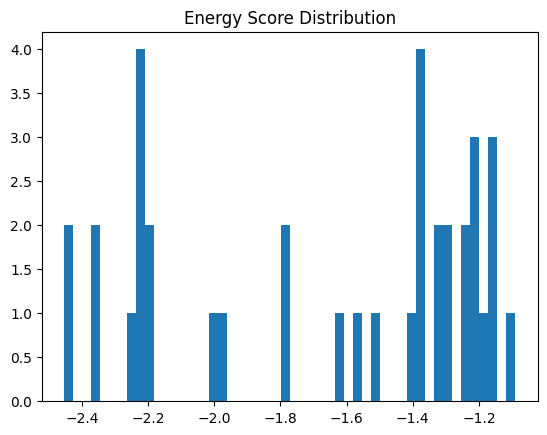

In [17]:
import matplotlib.pyplot as plt

energy_scores = []
confidence_scores = []
for text in val_texts:
    _, score = predict_with_intermediate_layer(text, energy_threshold=-1.5, confidence_threshold=0.5)
    energy_scores.append(score)
    # To get confidence, you might modify your function temporarily to also return max_confidence
plt.hist(energy_scores, bins=50)
plt.title("Energy Score Distribution")
plt.show()